# Домашка к уроку 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [192]:
%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

# Чтение данных
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


## п.2 там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [193]:
df.rename(columns = {'offer':'treatment', 'conversion':'target'}, inplace = True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [194]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [195]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [196]:
df['treatment'] = df['treatment'].map({
                                'Buy One Get One':1, 
                                'Discount':1,
                                'No Offer':0
                                }).astype(float)

In [197]:
df['treatment'].value_counts()

1.0    42694
0.0    21306
Name: treatment, dtype: int64

## п.4 сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [198]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1.0,0
1,6,329.08,1,1,Rural,1,Web,0.0,0
2,7,180.65,0,1,Surburban,1,Web,1.0,0
3,9,675.83,1,0,Rural,1,Web,1.0,0
4,2,45.34,1,0,Urban,0,Web,1.0,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1.0,0
63996,5,38.91,0,1,Urban,1,Phone,1.0,0
63997,6,29.99,1,0,Urban,1,Phone,1.0,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1.0,0


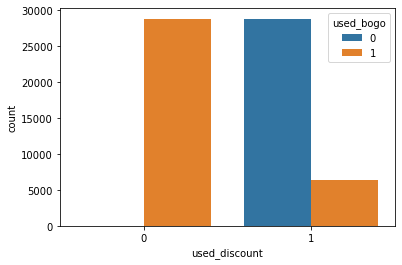

In [199]:
# смотрим, как зависят колонки 'used_discount' и 'used_bogo'

sns.countplot(x="used_discount", hue='used_bogo', data=df)
plt.show()

In [200]:
# видим зависимость. делаем новую колонку, которая будет принимать значение 0 или 1 или 2

df['used__'] = 0 

df.loc[(df['used_discount'] == 0), 'used__'] = 0 
df.loc[(df['used_discount'] == 1) & (df['used_bogo'] == 0),'used__'] = 1 
df.loc[(df['used_discount'] == 1) & (df['used_bogo'] == 1),'used__'] = 2 


df = df.drop(['used_discount', 'used_bogo'], axis = 1)

In [201]:
# нормируем колонки 'recency', 'history'

colls_norm = ['recency', 'history']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_norm = df.copy()
df_norm[colls_norm] = scaler.fit_transform(df_norm[colls_norm])

df = df_norm.copy()

In [202]:
# смотрим, что получилось

df.head(5)

,recency,history,zip_code,is_referral,channel,treatment,target,used__
0,1.207751,-0.389003,Surburban,0,Phone,1.0,0,1
1,0.067359,0.339614,Rural,1,Web,0.0,0,2
2,0.352457,-0.239836,Surburban,1,Web,1.0,0,0
3,0.922653,1.693278,Rural,1,Web,1.0,0,1
4,-1.073034,-0.768068,Urban,0,Web,1.0,0,1


## п.3 сделать разбиение набора данных не тренировочную и тестовую выборки

In [203]:
X_learn, X_valid = train_test_split(df, test_size=0.3, random_state=123) # выделяем Valid-выборку - 30%

In [204]:
# colls = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
colls = ['recency', 'history', 'used__', 'zip_code', 'is_referral', 'channel']
call_targ = ['treatment', 'target']

X_train = X_learn[colls] # это просто df без treatment и target
y_train = X_learn['target']  # это просто target
treat_train = X_learn['treatment']  # это просто treatment

X_val = X_valid[colls] 
y_val = X_valid['target'] 
treat_val =  X_valid['treatment'] 

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

## п.5 провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [205]:
# pip install scikit-uplift

In [206]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels


# СолоМодель
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_val)

# С трансформацией таргета
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})
uplift_ct = ct.predict(X_val)

# С двумя моелями
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
#     estimator_ctrl=GradientBoostingClassifier(learning_rate=7, random_state=42),
    method='vanilla')
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features})
uplift_tm = tm.predict(X_val)

In [207]:
def uplift_(sm_mod, mod_name):

    sm_score10 = uplift_at_k(y_true=y_val, uplift=sm_mod, treatment=treat_val, strategy='by_group', k=0.1)
    sm_score20 = uplift_at_k(y_true=y_val, uplift=sm_mod, treatment=treat_val, strategy='by_group', k=0.2)
    
    models_results['approach'].append(mod_name)
    models_results['uplift@10%'].append(sm_score10)
    models_results['uplift@20%'].append(sm_score20)   

In [208]:
uplift_(uplift_sm, 'SoloModel')
uplift_(uplift_ct, 'ClassTransformation')
uplift_(uplift_tm, 'TwoModels')

In [209]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.532924
1,treatment,19.721901
2,used__,15.772942
3,recency,13.536286
4,zip_code,10.689048
5,channel,10.510859
6,history,9.236039


## п.6 в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [210]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.098644,0.080171
2,TwoModels,0.094714,0.070782
0,SoloModel,0.079868,0.080943


## п.7 построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [211]:
X_train_ = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)

X_train_tree = pd.concat([X_train_.drop('channel', 1), 
                          pd.get_dummies(X_train_['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

In [ ]:
# !git clone https://github.com/ub8er/causalml.git
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

In [ ]:
# !pip install causalml
# !pip install graphviz

In [ ]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

In [ ]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

In [ ]:
graph.create_png()

In [ ]:
# !pip install graphviz
# !conda install graphviz

## п.8 (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

## п.9 (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево